#**DATA IMPORT AND PRE-PROCESSING**


In [29]:
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import numpy as np

In [30]:
from google.colab import files
import io
uploaded = files.upload()
df = pd.read_excel(io.BytesIO(uploaded['Dataset.xlsx']))

Saving Dataset.xlsx to Dataset (1).xlsx


In [31]:
fileName = "Dataset.xlsx"
df_Labels = pd.read_excel(fileName, sheet_name="Plant_1_Data")
df_Labels = df_Labels.drop(['PLANT_ID'], axis=1)
df_Labels["DATE_TIME"] = pd.to_datetime(df_Labels.DATE_TIME)
df_Features = pd.read_excel(fileName, sheet_name="Plant_1_Sensor_Data")
df_Features = df_Features.drop(['PLANT_ID','SOURCE_KEY'], axis=1)
df_Features['DATE_TIME'] = pd.to_datetime(df_Features.DATE_TIME)

In [32]:
df_Learn = pd.merge(df_Features, df_Labels, how='inner', left_on = ['DATE_TIME'], right_on = ['DATE_TIME'])

In [33]:
X = df_Learn.drop(['AC_POWER', 'DAILY_YIELD', 'TOTAL_YIELD','SOURCE_KEY'], axis = 1)
X['hour'] = X['DATE_TIME'].dt.hour
X['min'] = X['DATE_TIME'].dt.minute
X = X.drop(['DATE_TIME'], axis = 1)
y = df_Learn['DC_POWER']
type(X)

pandas.core.frame.DataFrame

# **10 Folds Cross Validation**

In [34]:
#folds                                                              
fold1 = X.loc[0:4567]                                           
fold2 = X.loc[4568:9135]
fold3 = X.loc[9136:13703]
fold4 = X.loc[13704:18271]
fold5 = X.loc[18272:22839]
fold6 = X.loc[22840:27407]
fold7 = X.loc[27408:31975]
fold8 = X.loc[31976:36543]
fold9 = X.loc[36544:41111]
fold10 = X.loc[41112:45679]

In [35]:
import copy
arrfolds=[fold1,fold2,fold3,fold4,fold5,fold6,fold7,fold8,fold9,fold10]
def makesplit(arrfolds):
  lm=[]
  for i in range(len(arrfolds)):
    #print(i)
    copy1=copy.deepcopy(arrfolds)
    xtest=copy1.pop(i)
    xtrain=pd.concat(copy1)
    ytrain=xtrain['DC_POWER']
    xtrain=xtrain.drop(['DC_POWER'],axis=1)
    ytest=xtest['DC_POWER']
    xtest=xtest.drop(['DC_POWER'],axis=1)
    lm.append([xtrain,xtest,ytrain,ytest])
  return lm
    
l=makesplit(arrfolds)


In [36]:
from sklearn.preprocessing import StandardScaler
def stdscale(x):
  cols_to_scale = ['AMBIENT_TEMPERATURE', 'MODULE_TEMPERATURE', 'IRRADIATION']
  scaler = StandardScaler()
  scaler.fit(x[0][cols_to_scale])
  x[0][cols_to_scale] = scaler.transform(x[0][cols_to_scale])
  x[1][cols_to_scale] = scaler.transform(x[1][cols_to_scale])
for i in range(len(l)):
  stdscale(l[i])

# **FEATURE REPRESENTATION**

## **1. CYCLICAL TRANSFORM**

In [37]:
!pip install feature_engine
from feature_engine.creation import CyclicalFeatures
def cycenc(x):
  cyclical = CyclicalFeatures(variables=['hour', 'min'], drop_original=True)
  cyclical.fit(x[0])
  x[0] = cyclical.transform(x[0])
  x[1] = cyclical.transform(x[1])
  
for i in range(len(l)):
  cycenc(l[i])

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


**Below 4 blocks of code performs feature transform. The code has been commented to make use of cyclical tranform only. Click on the links below to go to the notebook**

Factor Analysis

1.   [Factor Analysis](https://colab.research.google.com/drive/1lHZRN4XTzDXhPhPuU4bKUgvzoDN7gCmT#scrollTo=Xj0ocgt8-PrE)
2.   [Spline Transformer](https://colab.research.google.com/drive/1PKNU4Ak8f5kpWkQKnS0avK5VJkhsRH6D?usp=sharing)
3.   [Principal Component Analysis](https://colab.research.google.com/drive/1Wy3d0Yj2cbXPuoIkWgrD3oaM1vQ9E2iQ?usp=sharing)
4.   [Power Transformer](https://colab.research.google.com/drive/1-0PswnwNu-wGpSDgiA7fc4vCBEIcBUIZ?usp=sharing)

## 2. Factor **Analysis**

In [38]:
# from sklearn.decomposition import FactorAnalysis
# model = FactorAnalysis(n_components = 3, random_state=0)
# X = pd.DataFrame(model.fit_transform(X))

# reass = pd.concat([X, y], axis=1)
# reass
# X1=reass.drop(['DC_POWER'],axis=1)
# Y1=reass['DC_POWER']

## **3. Spline Transformer**

In [39]:
# from sklearn.preprocessing import SplineTransformer

# spline = SplineTransformer(degree=2, n_knots=3)
# spline.fit(X)
# X = pd.DataFrame(spline.transform(X))

## **4. Principal Component Analysis**

In [40]:
# from sklearn.decomposition import PCA
# pca = PCA(n_components=3) 
# pca.fit(X)
# X = pd.DataFrame(pca.transform(X))

# reass = pd.concat([X, y], axis=1)
# reass
# X1=reass.drop(['DC_POWER'],axis=1)
# Y1=reass['DC_POWER']

## **5. Power Transformer**

In [41]:
# from sklearn.preprocessing import PowerTransformer

# pt = PowerTransformer()
# pt.fit(X)
# X = pt.transform(X)
# X = pd.DataFrame(X)

# reass = pd.concat([X, y], axis=1)
# reass
# X1=reass.drop(['DC_POWER'],axis=1)
# Y1=reass['DC_POWER']

# **Error Bar Plot Function**

In [42]:
def errorbar(listrmse,listmse,listr2,listmae):
  
  labels = ['RMSE', 'R2', 'MAE']
  x_pos = np.arange(len(labels))
  CTEs = [abs(statistics.mean(listrmse)), abs(statistics.mean(listr2)), abs(statistics.mean(listmae))]
  error = [abs(statistics.pstdev(listrmse)), abs(statistics.pstdev(listr2)), abs(statistics.pstdev(listmae))]
  fig, ax = plt.subplots()
  ax.bar(x_pos, CTEs,
        yerr=error,
        align='center',
        alpha=0.5,
        ecolor='black',
        capsize=2)
  
  ax.set_xticks(x_pos)
  ax.set_xticklabels(labels)
  ax.set_title('Error Bar plots of RMSE, R2 Score, and MAE')
  ax.yaxis.grid(True)

  #Print metric values
  print('RMSE score: %.8f (SD: %.8f)' % (statistics.mean(listrmse), statistics.pstdev(listrmse)) )
  print('R2 score  : %.8f (SD: %.8f)' % (statistics.mean(listr2), statistics.pstdev(listr2)) )
  print('MAE score : %.8f (SD: %.8f)' % (statistics.mean(listmae), statistics.pstdev(listmae)) )
  print('MSE score : %.7f (SD: %.8f)' % (statistics.mean(listmse), statistics.pstdev(listmse)) )

  # Save the figure and show
  plt.tight_layout()
  plt.savefig('bar_plot_with_error_bars.png')
  plt.show()

# **LASSO MODEL TRAINING AND TESTS**

RMSE: 507.7203291130113
MSE: 274529.20012839267
MAE: 262.2325011978728
R2: 0.9828260066038814
p_val: 0.6799836948686296
t_stat: -0.03933775958829745
RMSE score: 507.72032911 (SD: 129.41896126)
R2 score  : 0.98282601 (SD: 0.01079391)
MAE score : 262.23250120 (SD: 41.08331415)
MSE score : 274529.2001284 (SD: 150675.99639064)


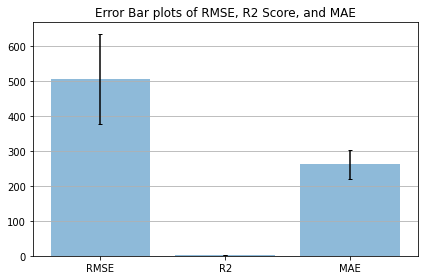

In [43]:
# Importing libraries
import sklearn
from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error
from sklearn.metrics import r2_score
import statistics
from numpy import absolute
import scipy.stats as stats



import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

# Lasso Regression

class LassoRegression() :
	
	def __init__( self, learning_rate, iterations, l1_penality):		
		self.learning_rate = learning_rate
		self.iterations = iterations
		self.l1_penality = l1_penality
		
	# Function for model training
			
	def fit( self, X_train, Y_train ) :
		# no_of_training_examples, no_of_features
		self.m, self.n = X_train.shape

		# weight initialization
		self.Weight = np.zeros(self.n)
		self.b = 0
		self.X_train = X_train
		self.Y_train = Y_train

		# gradient descent learning
		for i in range(self.iterations):
			self.update_weights()
		return self

	# Helper function to update weights in gradient descent
	def update_weights(self):
		Y_pred = self.predict(self.X_train)
	
		# calculate gradients
		dW = np.zeros(self.n)
		for j in range(self.n):
			if self.Weight[j] > 0:
				dW[j] = (-(2*(self.X_train.iloc[:, j]).dot(self.Y_train - Y_pred)) + self.l1_penality)/self.m
			else :
				dW[j] = (-(2*(self.X_train.iloc[:, j]).dot(self.Y_train - Y_pred)) - self.l1_penality)/self.m
		db = - 2 * np.sum( self.Y_train - Y_pred ) / self.m

		# update weights
		self.Weight = self.Weight - self.learning_rate * dW
		self.b = self.b - self.learning_rate * db
		return self

	# Hypothetical function h( x )
	
	def predict(self, X_test) :
		return X_test.dot(self.Weight) + self.b
	

model = LassoRegression( iterations =1000, learning_rate = 0.1, l1_penality = 500 )
listrmse=[]
listmse=[]
listmae=[]
listr2=[]
pvals=[]
tvals=[]

for i in l:
	model.fit(i[0], i[2])
	Y_pred = model.predict(i[1])
	Y_pred.where(Y_pred>0,0)
	rmse=mean_squared_error(i[3],Y_pred,squared=False)
	mse=mean_squared_error(i[3],Y_pred)
	mae=mean_absolute_error(i[3],Y_pred)
	r2=r2_score(i[3],Y_pred)
	tstat, t_pval = stats.ttest_ind(a=Y_pred, b=i[3], equal_var=True)


	# display("T-Statistic: " + str(tstat.round(3)), "PValue: " + str(t_pval.round(3)))


	listrmse.append(rmse)
	listmse.append(mse)
	listmae.append(mae)
	listr2.append(r2)
	pvals.append(t_pval)
	tvals.append(tstat)

#	print(listrmse)
print("RMSE:",statistics.mean(listrmse))
#	print(listmse)
print("MSE:", statistics.mean(listmse))
#	print(listmae)
print("MAE:", statistics.mean(listmae))
#	print(listr2)
print("R2:", statistics.mean(listr2))
# print(pval)
print("p_val:", statistics.mean(pvals))
# print(tstat)
print("t_stat:", statistics.mean(tvals))
errorbar(listrmse,listmse,listr2,listmae)


# **L2** **Regularization**

In [44]:
X_train = np.column_stack(([1]*l[0][0].shape[0], l[0][0]))# add a column with ones for the bias value while converting it into a matrix
X_test = np.column_stack(([1]*l[0][1].shape[0], l[0][1]))
m,n = X_train.shape # rows and columns 
theta = np.array([1] * n) # initial theta
X = np.array(X_train) # convert X_train into a numpy matrix
y = l[0][2].values.flatten() # convert y into an array

alpha = 0.1 # alpha value 
iteration = 1000 # iterations
lam = 0.1

In [45]:
cost_l2 = []
theta_l2 = theta
for i in range(iteration):
    pred = np.matmul(X,theta_l2)
    J = 1/(2*m) * np.sum(np.square(pred-y)) + (lam*np.sum(np.square(theta_l2)))
    cost_l2.append(J)
    d_theta_l2 = 1/m * np.dot(X.T,(pred-y)) + (lam*2*theta_l2)
    theta_l2 = theta_l2 - alpha*d_theta_l2

In [46]:
y_pred = np.matmul(X_test, theta_l2)
rmse=mean_squared_error(l[0][3],y_pred,squared=False)
mse=mean_squared_error(l[0][3],Y_pred)
mae=mean_absolute_error(l[0][3],Y_pred)
r2=r2_score(l[0][3],Y_pred)
tstat, t_pval = stats.ttest_ind(a=Y_pred, b=l[0][3], equal_var=True)
print("RMSE:",rmse)
#	print(listmse)
print("MSE:", mse)
#	print(listmae)
print("MAE:", mae)
#	print(listr2)
print("R2:",r2 )
# print(pval)
print("p_val:",t_pval )
# print(tstat)
print("t_stat:",tstat )

RMSE: 699.6820339862533
MSE: 22254135.962595865
MAE: 3432.3828603720776
R2: -0.9658105615063743
p_val: 0.0009749497732907186
t_stat: -3.298729589829249


# **Linear Regression with sgd**

The code has been commented because the input paramaetrs that is used is different I was finidng it difficult to integrate it with this common code. Below is the main sgd_regressor function from scratch. Click [here](https://colab.research.google.com/drive/1cnvKkb5zRWLiG-WqKG0vny5H8B62j9xA#scrollTo=0FeeZw0brO2W) for the notebook.

In [47]:
# from sklearn.metrics import mean_squared_error
# def sgd_regressor(X, y, learning_rate=0.5, n_epochs=1000, k=40):
    
#     w = np.random.randn(1,7)  # Randomly initializing weights
#     b = np.random.randn(1,1)   # Random intercept value
    
#     epoch=1
    
#     while epoch <= n_epochs:
        
#         temp = X.sample(k)

#         X_tr = temp.iloc[:,0:7].values
#         y_tr = temp.iloc[:,-1].values
        
#         Lw = w
#         Lb = b
        
#         loss = 0
#         y_pred = []
#         sq_loss = []
        
#         for i in range(k):
              
#             Lw = (-2/k * X_tr[i]) * (y_tr[i] - np.dot(X_tr[i],w.T) - b)
#             Lb = (-2/k) * (y_tr[i] - np.dot(X_tr[i],w.T) - b)
            
#             w = w - learning_rate * Lw
#             b = b - learning_rate * Lb
            
#             y_predicted = np.dot(X_tr[i],w.T)
#             y_pred.append(y_predicted)
        
#         loss = mean_squared_error(y_pred, y_tr)
            
#         print("Epoch: %d, Loss: %.3f" %(epoch, loss))
#         epoch+=1
#         learning_rate = learning_rate/1.02
        
#     return w,b